In [2]:
import numpy as np
from astropy import units as u
from astropy import constants as const
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
# home = '/Users/lieke/surfdrive/Documents/'
# proj_dir = home + 'CEinLISA/'


## LISA strain simple approx

In [3]:
m1 = 0.5*u.Msun
m2 = 0.3*u.Msun
# Porb = 0.5*u.day#*24.*60.*60.   # s

def Pkeppler(m1, m2, a):
    a = a.to(u.m)
    m1 = m1.to(u.kg)
    m2 = m2.to(u.kg)
    P = (( (2*np.pi)**2 * a**3)* (const.G * (m1 + m2))**-1 )**0.5
    return P.to(u.day)

a = 1.47*u.Rsun
print('Pkeppler',Pkeppler(m1, m2, a))
Porb = Pkeppler(m1, m2, a)

f_gw = 2.*((Porb.to(u.s))**-1)  # Hz
print('f_gw', np.log10(f_gw.value) )

def chirpmass(m1,m2):
    return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

mchirp = ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))
print( 'mchirp', mchirp)
mchirp = mchirp.to(u.kg)
print( 'mchirp', mchirp)

d = 100*u.pc#6e4 # pc
d = d.to(u.m)
# d_AU = d*u.pc.to(u.AU)
# f_gw_day = f_gw/(u.s.to(u.day))

A_mean = (2.*((const.G*mchirp)**(5./3.))/((const.c**4.)*d))*((np.pi*f_gw)**(2./3.))
print('A_mean', A_mean)
Tobs = 10. *u.yr  # yrs
Tobs = Tobs.to(u.s)
# Tobs_s = Tobs*365.25*24.*60.*60.
hc = A_mean*np.sqrt(f_gw*Tobs)

print('hc',  np.log10(hc) )

Pkeppler 0.23082047081033671 d
f_gw -3.9987580693476845
mchirp 0.334993791331143 solMass
mchirp 6.66126918352894e+29 kg
A_mean 2.0728688618498186e-22
hc -19.43325522341097


In [5]:
m1 = 0.5
m2 = 0.5
mchirp = ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))
print('mchirp',mchirp )


mchirp 0.43527528164806206


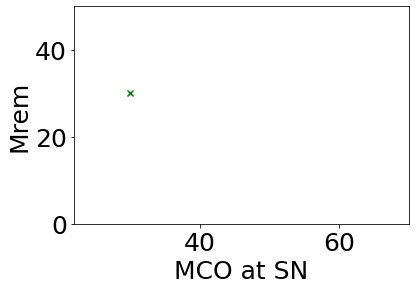

In [6]:
# overplot figures to get a beta value

# img = plt.imread("/Users/lieke/Documents/screenshots/Fragos2019.png")
# fig, ax = plt.subplots(figsize = (10,10))
# ax.imshow(img, extent=[22, 70, 0, 50])

# plt.scatter(snfarmCO['MassCOCoreSN'], snfarmCO['Mrem'], alpha = 0.5, label = 'Farmer CO core 2019',s = 25, c = 'limegreen')
plt.scatter(30,30, marker = 'x', c = 'green')

# xlijst = np.arange(22,70, 0.5)
# print(len(xlijst))
# plt.plot(xlijst,  farm_theory(xlijst, z = 1e-3), alpha = 1, label = '',c = 'white', linewidth = 4)
# xmax = -8.564/(2*-0.096)
# print('max Mrem = ', farm_theory([xmax], z = 1e-3))

plt.xlabel('MCO at SN', fontsize = 25)
plt.ylabel('Mrem', fontsize = 25)
# plt.legend(loc = 'lower left', fontsize = 25, framealpha = 1)

plt.xlim(22,70)
plt.ylim(0,50)

plt.tick_params(axis='both', which='major', labelsize=25) #right side
# plt.savefig('/home/ason/BHinPISNgap/Plots/Farmer/Compare_plot_Mco_Mrem.png', bbox_inches='tight')

plt.show()


In [7]:
m1 = 1.6*u.Msun
m2 = 0.3*u.Msun
a = 126 * u.Rsun
Porb = Pkeppler(m1, m2, a)
print(Porb)



118.85633409283827 d


# Calculating the final separations for theoretical RSGs



In [4]:
def Menv(Mc):
    ## given a He core mass, returns the envelope mass
    ## calculated as M_env = Mtot-Mcore
    ## read data on Mathieu's workstation from binary_c
    dataFile = "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/binary_c_core_masses.txt"
    F = open(dataFile,"r")
    for i, line in enumerate(F):
        if i==0:
            col = line.split()
            break
    F.close()
    data = np.genfromtxt(dataFile,skip_header=1)
    # filter MS longer than age of the Universe
    t_tams = data[:,col.index("MS_duration")]
    ind = t_tams < 13700
    Mass = data[ind, col.index("mass")]
    Mcore = data[ind, col.index("core_mass")]
    Mtot = np.interp(Mc,Mcore, Mass, left=0)
    Menv = Mtot - Mc
    #sanity check
    # fig, ax = plt.subplots(figsize=(12,10))
    # ax.plot(Mcore, M)
    # ax.set_xlabel(r"$M_\mathrm{He} \ [M_\odot]$", size=30)
    # ax.set_ylabel(r"$M_\mathrm{tot} \ [M_\odot]$", size=30)
    # ax.axvline(Mc)
    # ax.axhline(Mtot)    
    return Menv
# test
Menv(5) #np.arange(0.6,10,0.01))    

13.662520325203253

3.2944589982425305 solMass 36.44054955752214 solMass


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


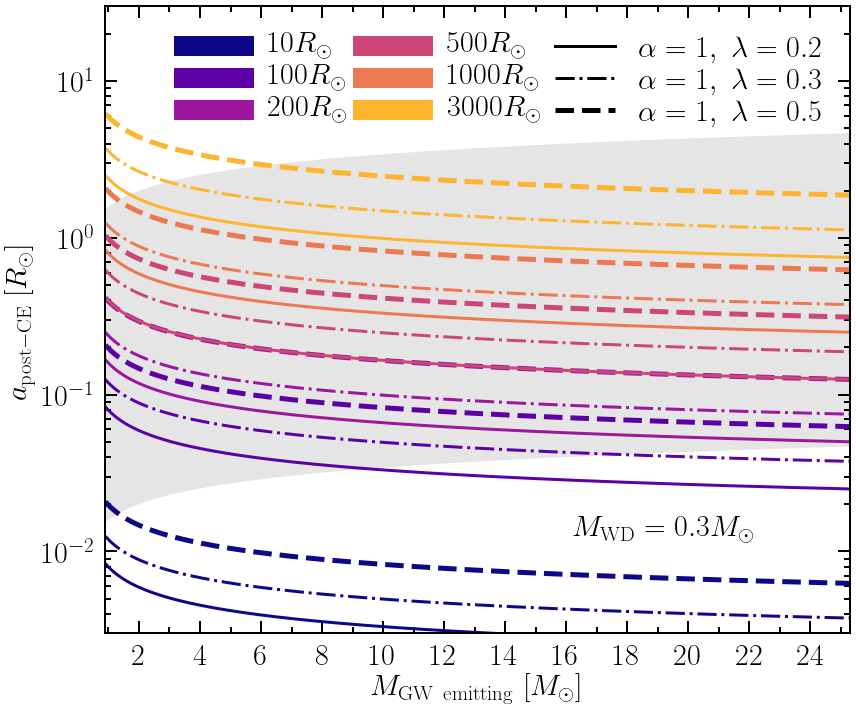

In [5]:
rainbow = plt.cm.plasma(np.linspace(0.0,1,7) ) #3rd num is the number of colours

def Rrl(a, m1, m2):
    #RL1 for q = m1/m2
    q = m1/m2
    RL = a * 0.49 * q**(2./3) *(0.6 * q**(2./3) +np.log(1 + q**(1./3)) )**-1
    return RL
    
def aLISA(mass):
    min_freq = 1e-4 *u.s**-1
    mass = mass.to(u.kg)
    a = pow(const.G * mass * (np.pi * min_freq)**-2, 1./3. )
    return a.to(u.Rsun)

def aLISAexit(mass):
    min_freq = 1e-1 *u.s**-1
    mass = mass.to(u.kg)
    a = pow(const.G * mass * (np.pi * min_freq)**-2, 1./3. )
    return a.to(u.Rsun)

def afinal(Mdcore = 1*u.Msun, Mdenv= 1*u.Msun, Mcomp= 1*u.Msun, a_ent= 1*u.Rsun, alpha=1.0, Lambda= 0.2):
    ## Mathieu: based on Fig. 1 in de Marco et al. 2011, lambda=0.2-0.3 is more realistic.
    Mdon = Mdcore + Mdenv
    Rrld = Rrl(a_ent, Mdon, Mcomp)
    # print('Rrld', Rrld)
    afinal = (Mdcore*Mcomp)/2 * ( (Mdon*Mdenv)/(Lambda*Rrld) + (Mdon*Mcomp)/(2*a_ent) )**-1
    return afinal

# print('afinal', afinal(Mdcore = 0.5*u.Msun, Mdenv = 1.1*u.Msun, Mcomp= 0.3*u.Msun, a_ent= 100*u.Rsun, alpha=1., Lambda=0.2) )
# afinal_Ivanova = afinal(Mdcore = 0.5*u.Msun, Mdenv = 1.1*u.Msun, Mcomp= companion_mass, a_ent= 100*u.Rsun, alpha=1., Lambda=0.5) )

def plot_afinal_Mgw(companion_mass = 0.3):
    #companion_mass The withe dwarf falling into the envelope

    fig, ax = plt.subplots(figsize=(12,10))
   
    core_masses = np.arange(0.6, 25, 0.01) #Donor core masses
    # Mathieu: for core mass less than 0.6 the envelope mass from BSE is negative (guess those stars live longer than the universe!)
    # np.arange(0.1, 10, 0.01) #Donor core masses
    masses = core_masses + companion_mass

    donor_envelope_masses = Menv(core_masses)*u.Msun # core_masses *2*u.Msun   #ballpack estimate
    print(min(donor_envelope_masses), max(donor_envelope_masses))
    #Add units
    companion_mass = companion_mass*u.Msun 
    core_masses = core_masses*u.Msun
    masses = masses*u.Msun

    a_enters = np.logspace(1, 3, 3)
    a_enters = np.append(a_enters, 200)
    a_enters = np.append(a_enters, 500)
    a_enters = np.append(a_enters, 3000)
    a_enters = np.sort(a_enters)
    for i, a in enumerate(a_enters):
        # print(a)
        afinals = afinal(Mdcore = core_masses, Mdenv = donor_envelope_masses, Mcomp= companion_mass, a_ent= a*u.Rsun, alpha=1., Lambda=0.2) 
        plt.plot(masses, afinals, # label = 'afinal, aent = '+str(a),
                 lw=3,c = rainbow[i] )
        afinals = afinal(Mdcore = core_masses, Mdenv = donor_envelope_masses, Mcomp= companion_mass, a_ent= a*u.Rsun, alpha=1., Lambda=0.3) 
        plt.plot(masses, afinals, # label = 'afinal, aent = '+str(a),
                 ls='-.',lw=3, c = rainbow[i] )
        afinals = afinal(Mdcore = core_masses, Mdenv = donor_envelope_masses, Mcomp= companion_mass, a_ent= a*u.Rsun, alpha=1., Lambda=0.5) 
        plt.plot(masses, afinals, # label = 'afinal, aent = '+str(a),
                 ls='--',lw=5, c = rainbow[i] )

    # for legend
    for i, a in enumerate(a_enters):
        ax.plot(np.nan, np.nan, ls='-', lw=20, label=r"%.0f"%float(a)+"$R_\odot$", c= rainbow[i])
    ax.plot(np.nan, np.nan, ls='-', c='k',lw=3, label=r"$\alpha=1,\ \lambda=0.2$")
    ax.plot(np.nan, np.nan, ls='-.',c='k',lw=3, label=r"$\alpha=1,\ \lambda=0.3$")
    ax.plot(np.nan, np.nan, ls='--',c='k',lw=5, label=r"$\alpha=1,\ \lambda=0.5$")
        
    ax.fill_between(masses, aLISAexit(masses), aLISA(masses), facecolor='#808080',  alpha=0.2, zorder=0)
    # plt.plot(masses, aLISA(masses), c = '#808080', lw=2, ls='-',  zorder=0) # label = 'aLISA enter',
    # plt.plot(masses, aLISAexit(masses), c = '#808080',lw=2, linestyle='-',  zorder=0) # label = 'aLISA exit',

    plt.text(0.75, 0.16, r'$M_\mathrm{WD}='+str(companion_mass.value)+r'M_\odot$', fontsize = 30, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
    l = ax.legend(fontsize = 30, loc = 'upper right', ncol=3, columnspacing=0.5, labelspacing=0.1)
    l.draw_frame(False)
    plt.xlabel(r'$M_\mathrm{GW\ emitting}\ [M_\odot]$',size = 30)
    plt.ylabel(r'$a_\mathrm{post-CE}\ [R_\odot]$',size = 30)
    plt.tick_params(axis='both', which='major', labelsize=25) #right side
    plt.yscale('log')
    ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
    ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    # ax.yaxis.set_major_locator(MultipleLocator(5))
    # ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylim(3e-3,30)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ## annotate the effect of changing $\alpha$    
    ax.set_xlim(min(masses.value), max(masses.value))
    plt.tight_layout()
    plt.savefig('many_lambdas'+str(companion_mass.value).replace('.', 'd')+'.pdf', bbox_inches='tight')
    plt.show()
    

plot_afinal_Mgw(companion_mass = 0.3)

3.2944589982425305 solMass 36.44054955752214 solMass


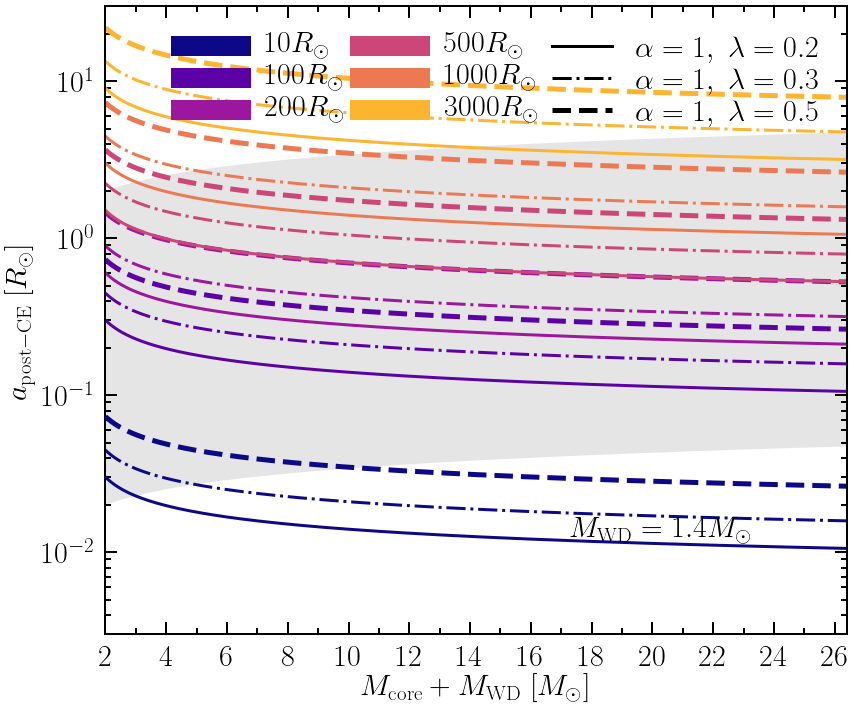

In [14]:
# plot_afinal_Mgw(companion_mass = 0.5)
plot_afinal_Mgw(companion_mass = 1.4)

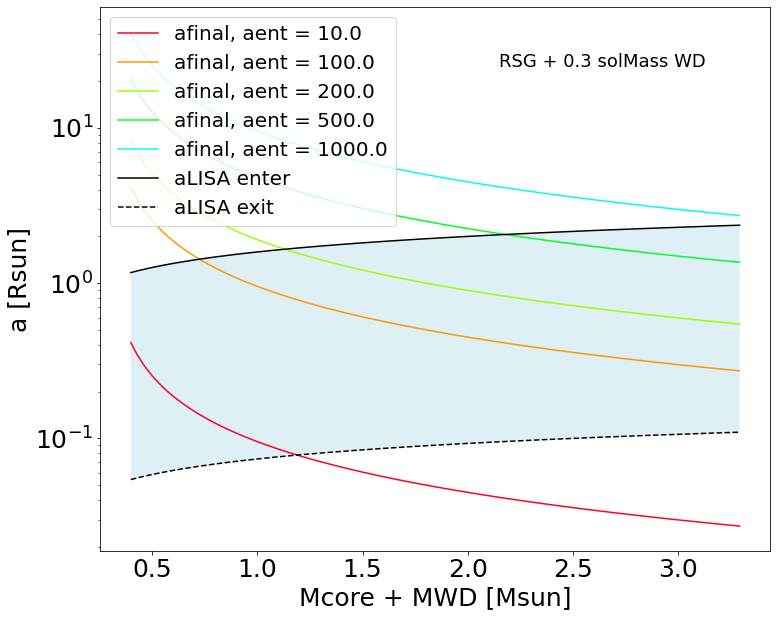

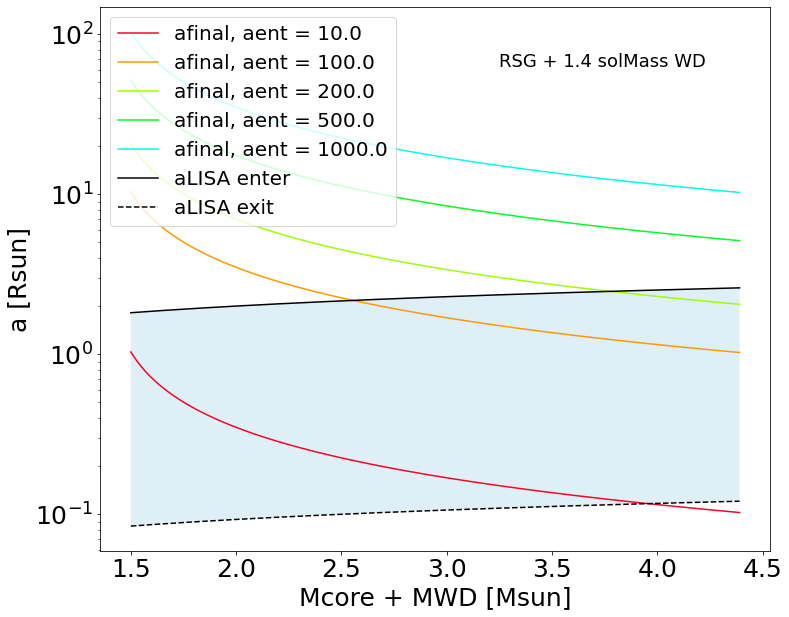

In [19]:
plot_afinal_Mgw(companion_mass = 0.3)

plot_afinal_Mgw(companion_mass = 1.4)


# Calculation of Fdtot for gas drag (optimistic upper end for f, fdot evolution)

chirp mass 0.8705505632961241
rho0 999999999.9999999 kg / m3 
 cs 30000.0 m / s 
 M 3.976819741396102e+30 kg 
 fgw [1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00] 1 / s
unit of fGWdot: 1 / s2
fGWdot [  -13.51643824   -26.73982501   -52.89990073  -104.65287252
  -207.03675384  -409.58471956  -810.2891848  -1603.01039481
 -3171.26573335 -6273.7748826 ] 1 / s2
unit of fgrav: 1 / s
[-4.         -3.55555556 -3.11111111 -2.66666667 -2.22222222 -1.77777778
 -1.33333333 -0.88888889 -0.44444444  0.        ] [ 8.62996623  8.92626253  9.22255882  9.51885512  9.81515142 10.11144771
 10.40774401 10.70404031 11.0003366  11.2966329 ]
fdotP unit 1 / s2
fdotP [9.91075559e-22 4.22412144e-20 1.80038765e-18 7.67353812e-17
 3.27058383e-15 1.39397477e-13 5.94134188e-12 2.53229428e-10
 1.07930404e-08 4.60016525e-07] 1 / s2


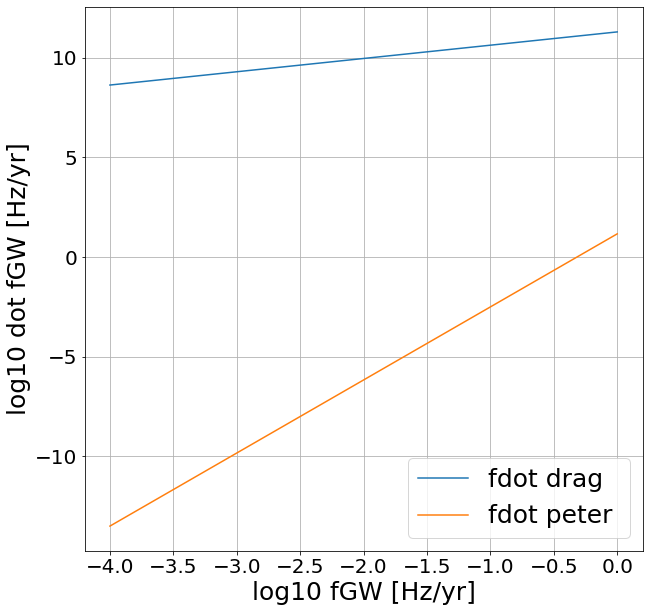

In [103]:
def chirpmass(m1,m2):
    return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))


def dotfGW(rho0, cs, M, fGW):
    rho0 = rho0.to(u.kg/u.m**3)
    cs = cs.to(u.m/u.s)
    M = M.to(u.kg)
    fGW = fGW.to(1/u.s)
    print('rho0', rho0,'\n cs', cs, '\n M', M,'\n fgw', fGW)
    fGWdot = -3 * np.pi**(-1./3) * rho0 * cs**(-2) *(const.G)**(5./3.) * M**(2./3) * fGW**(2./3)
    print('unit of fGWdot:',fGWdot.unit)
    print('fGWdot', fGWdot)
    return fGWdot


def fdot_peters(m1, m2, fGW):
    Mchirp = chirpmass(m1,m2)
    Mchirp = Mchirp*u.Msun
    Mchirp = Mchirp.to(u.kg)
    fGW = fGW.to(1/u.s)
    fdotP = 96./5. * np.pi**(8./3) * const.c**(-5) * (const.G * Mchirp)**(5./3) *fGW**(11./3.)
    print('fdotP unit', fdotP.unit)
    print('fdotP', fdotP)
    return fdotP
    

fig, ax = plt.subplots(figsize=(10,10))

    
cs = 3e6 * u.cm/u.s
pnot = 1e6 *u.g/u.cm**3

fgrav = np.logspace(-4, 0, 10) * 1/u.s #1e-3 * 1/u.s #np.logspace(-4, -2, 10) * 1/u.s
companion_mass = 1.
core_masses = 1. #np.linspace(0.1, 3, 10) #Donor core masses
mtot = companion_mass + core_masses
print('chirp mass', chirpmass(companion_mass,core_masses))

masses = core_masses + companion_mass
masses = masses * u.Msun


fdotGW = dotfGW(pnot, cs, masses, fgrav)
fdotGW = fdotGW.to(u.Hz/u.yr)
print('unit of fgrav:',fgrav.unit)    
print(np.log10(fgrav.value), np.log10(np.abs(fdotGW.value) ) )
plt.plot(np.log10(fgrav.value), np.log10(-fdotGW.value), label = 'fdot drag ')


fdotP = fdot_peters(companion_mass, core_masses, fgrav)
fdotP = fdotP.to(u.Hz/u.yr)
plt.plot(np.log10(fgrav.value), np.log10(fdotP.value), label = 'fdot peter ')



plt.xlabel('log10 fGW [Hz/yr]', fontsize = 25)
plt.ylabel('log10 dot fGW [Hz/yr]', fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=20) #right side
plt.grid()
plt.legend(fontsize = 25)
plt.show()
